## Base dos Dados Python 101

### TL;DR

Neste artigo vamos demonstrar como usar o pacote da Base dos Dados em Python para acessar e usar os dados disponíveis em nosso repositório público, com o conteúdo do Workshop "[Brincando com dados da BD+ em Python](https://www.youtube.com/watch?v=wI2xEioDPgM)".  

O pacote tem diversas funções que permitem listar os conjuntos de dados disponíveis, obter informações sobre as tabelas, carregar os dados direto no pandas, dentre muitas outras. Como exemplo, **exploramos os dados da tabela de nomes brasileiros do IBGE (2010)** e mostramos como criar uma visualização de nuvem de palavras dos nomes mais frequentes.

### Como acessar a BD+ em Python?

A Base dos Dados Mais (BD+) é o nosso *datalake* de dados públicos **limpos, integrados e atualizados** pela nossa equipe de dados - dados prontos para análise.

O datalake é mantido no Google BigQuery e tem custo praticamente zero para todos os usuários - você tem 1 TB disponível por mês para fazer consulta aos dados. Para facilitar ainda mais a vida de Pythonistas, criamos um pacote de acesso direto ao repositório via Python: `basedosdados`

In [ ]:
!pip install basedosdados

In [ ]:
import numpy as np
import basedosdados as bd

**Atenção!** É necessário criar um projeto no Google Cloud e autenticar seu projeto para fazer consultas aos dados do repositório. Caso você rode qualquer função do pacote pela primeira vez, as instruções para essa configuração irão aparecer para você e basta seguir o passo a passo apresentado.

Existem diversas funções no pacote, tanto para acesso quanto para publicação de dados no nosso ou em qualquer projeto do Google Cloud - você pode usar o pacote para construir seu próprio repositório de dados também.

> A lista completa dos módulos do pacote está na [nossa documentação](https://basedosdados.github.io/mais/py_reference_api/), e veja também como colaborar [subindo dados no repositório](https://basedosdados.github.io/mais/colab_data/).

### Explorando as funções do pacote

Para ilustrar, podemos verificar todos os conjuntos de dados disponíveis no repositório usando a função `list_datasets`. Essa função retorna todos os conjuntos de dados no repositório e que podem ser filtrados por algum termo específico, com o parâmetro `filter_by`, como fazemos abaixo buscando dados do IBGE. O parâmetro `with_description` indica se queremos visualizar também a descrição de cada conjunto.

In [ ]:
bd.list_datasets(filter_by='ibge', with_description=True)

Da mesma forma, podemos listar as tabelas de um conjunto de dados específico com a função `list_dataset_tables`. Além disso, podemos ter também uma visão completa das colunas e seus tipos com a função `get_table_columns` - tudo isso sem carregar ainda os dados no ambiente!

In [ ]:
bd.list_dataset_tables(dataset_id='br_ibge_nomes_brasil', with_description=True)

In [ ]:
bd.get_table_columns(
    dataset_id='br_ibge_nomes_brasil',
    table_id='quantidade_municipio_nome_2010'
)

Antes de carregar os dados, pode-se verificar inclusive seu tamanho total - existem tabelas muito grandes no repositório, então recomendamos fortemente fazer esse passo.

In [ ]:
bd.get_table_size(
    dataset_id='br_ibge_nomes_brasil',
    table_id='quantidade_municipio_nome_2010',
    billing_project_id='basedosdados42'
)

Por fim, a função `read_table` faz o carregamento dos dados no ambiente Python. Caso a base em questão seja muito grande, você pode optar também em usar a função `read_sql`, que permite fazer uma query SQL e carregar no ambiente somente os dados requisitados. Para ambos é necessário que você explicite o seu `billing_project_id`, o projeto que foi habilitado lá no início e que será cobrado caso você exceda o limite.

In [ ]:
df = bd.read_table(
    dataset_id='br_ibge_nomes_brasil',
    table_id='quantidade_municipio_nome_2010',
    billing_project_id='basedosdados42'
)

Neste exemplo vamos trabalhar com os dados de [nomes brasileiros do Censo Demográfico 2010 do IBGE](https://basedosdados.org/dataset/br-ibge-nomes-brasil). De acordo com o Censo, existem ao todo cerca de 200 milhões de habitantes com mais de 130 mil nomes diferentes espalhados pelo Brasil. Curioso? Nós também!

### Quais são os nomes mais famosos no Brasil?

Quem você diria que é mais famoso: Maria ou João? É isso o que queremos descobrir primeiro com os nossos dados.

Para respondermos a essa pergunta, nós vamos contar a frequência de cada nome no país e ordená-los, e em seguida criar uma nuvem de palavras para visualização dessas informações.

Criamos então a função `generate_list_sorted_by_freq` que faz a agregação dos nomes contando quantas vezes cada um aparece na nossa base, e ordena essa lista de acordo com os nomes mais frequentes. A função pode ser lida abaixo.

In [ ]:
def generate_list_sorted_by_freq(df):
    name_freq = df.groupby('name').freq.sum() # agrupamento de nomes iguais
    name_freq = name_freq.sort_values(ascending=False) # ordenação dos nomes por frequência
    name_freq = name_freq.reset_index() # inicializa o index de um dataframe criando um se necessário
    return name_freq

df = df.rename(columns={'qtde_nascimentos_ate_2010': 'freq', 'nome': 'name'})
name_freq = generate_list_sorted_by_freq(df)

Para criar uma nuvem de palavras, vamos usar a biblioteca `wordcloud` junto ao `matplotlib` disponíveis para instalação via pip. A `wordcloud` nos possibilita gerar uma imagem com as palavras mais frequentes e o tamanho de cada palavra é determinado pela sua frequência, gerando um belo efeito visual para nosso ranking.

In [ ]:
!pip install wordcloud # caso não tenha a biblioteca já instalada
!pip install matplotlib # caso não tenha a biblioteca já instalada

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

A função `fit_words` da classe `WordCloud` recebe como input um dicionário com a palavra escolhida como chave e a frequência do nome no Brasil como valor correspondente. Vamos então montar esse dicionário e criar a função `visualize_wordcloud` que define as configurações gerais do gráfico que iremos gerar.

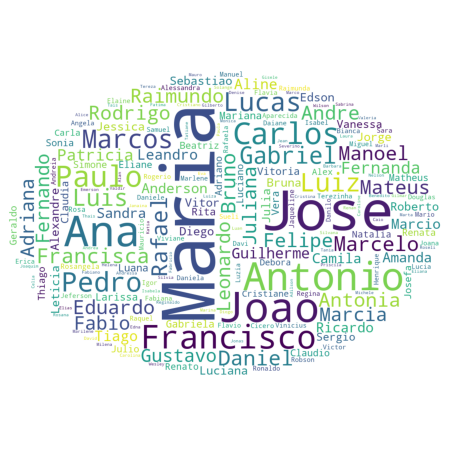

In [14]:
def visualize_wordcloud(word_dict):
    x, y = np.ogrid[:1000, :1000]
    mask = 2*(x - 500) ** 2 + (y - 500) ** 2 > 500 ** 2
    mask = 255 * mask.astype(int)

    wc = WordCloud(background_color="white", mask=mask)
    wc.fit_words(word_dict)
    
    plt.rcParams["figure.figsize"] = 8, 8
    plt.axis("off")
    plt.imshow(wc)
    plt.show()

name_freq_dict = name_freq.to_dict(orient='records')
name_freq_dict = {r['name']:r['freq'] for r in name_freq_dict}

visualize_wordcloud(name_freq_dict)

**E como resultado: Maria é a vencedora!** O que achou dessa descoberta? No próximo texto vamos trazer uma análise regional construída pelo Fred também no Workshop, para acessar todo o conteúdo apresentado basta acessar a Base dos Dados no Youtube.